In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import sncosmo
from astropy.table import Table
import matplotlib.pyplot as plt
import warnings

project_root = Path.cwd().parent
print(f"Project root: {project_root}")

In [ ]:
# User input: run folder name
folder_name = input("Enter the run folder name: ").strip()
run_folder = project_root / "runs" / folder_name

lightcurve_files = sorted(run_folder.glob("*_lightcurve.csv"))
print(f"Found {len(lightcurve_files)} lightcurve CSV in {run_folder}")
for f in lightcurve_files:
    print(f"{f.name}")

Processing file 1/1: ZTF19aamhqej_lightcurve.csv
{'ztfg', 'ztfr'}
       time        band        flux             fluxerr        zp  zpsys
------------------ ---- ------------------ ------------------ ---- -----
 58557.49618060002 ztfg  427.0906064435389  21.75859108181046 23.9    ab
 58557.53449069988 ztfr  410.3171404562258  20.27708524040657 23.9    ab
 58560.46936339978 ztfr   936.181745157504 26.797168404514053 23.9    ab
 58560.51104169991 ztfg 1018.3094902898022  33.45199587052541 23.9    ab
58567.510868099984 ztfg 2347.4691809888204 102.82078451115405 23.9    ab
 58567.53346059984 ztfr   2176.90783329272   58.3837755147141 23.9    ab
 58572.47026620014 ztfr  2274.468670795369 55.285530147289016 23.9    ab
 58572.50520829996 ztfg  2499.884812938381  65.52624869133274 23.9    ab
 58575.46699069999 ztfr  2381.222221692321  54.27917722048485 23.9    ab
 58575.51166669978 ztfg  2230.282274421634  82.08857954010212 23.9    ab
               ...  ...                ...                

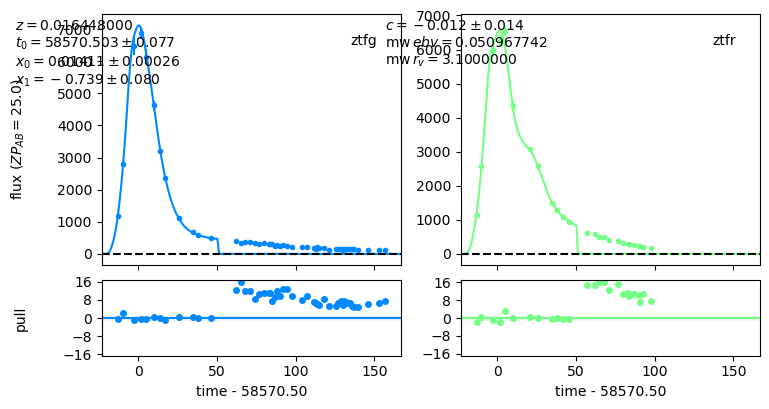

In [ ]:
ztf_cleansed_path = project_root / "ztf_cleansed.csv"
ztf_df = pd.read_csv(ztf_cleansed_path)

# Initialize list to collect results
results_list = []

for idx, lc_path in enumerate(lightcurve_files, 1):
    print(f"Processing file {idx}/{len(lightcurve_files)}: {lc_path.name}")
    lc_df = pd.read_csv(lc_path)

    # clean
    lc_df['MJD'] = pd.to_numeric(lc_df['MJD'], errors='coerce')
    lc_df = lc_df.dropna(subset=['MJD', 'filter', 'forced_ujy', 'forced_ujy_error'])
    lc_df['filter'] = lc_df['filter'].astype(str).str.strip().str.lower()
    lc_df = lc_df[lc_df['forced_ujy'] > 0]
    lc_df = lc_df[lc_df['forced_ujy_error'] > 0]
    lc_df = lc_df.sort_values('MJD')

    bands = lc_df['filter'].map({'g': 'ztfg', 'r': 'ztfr'}).values

    data = Table({
        'time': lc_df['MJD'].values,
        'band': bands,
        'flux': lc_df['forced_ujy'].values,
        'fluxerr': lc_df['forced_ujy_error'].values,
        'zp': np.full(len(lc_df), 23.9),
        'zpsys': np.array(['ab'] * len(lc_df)),
    })
    print(set(bands))
    print(data)
    print(f"  Loaded {len(data)} data points after cleaning.")

    # add dust
    dust = sncosmo.CCM89Dust()
    Rv = 3.1 # Milky Way extinction law

    model = sncosmo.Model(
        source="salt3",
        effects=[dust],
        effect_names=["mw"],
        effect_frames=["obs"],
    )
    obj_id = lc_df['ztf_id'].iloc[0]

    # get A_V and set mwebv to add MW dust extinction
    z_row = ztf_df.loc[ztf_df['ZTFID'] == obj_id]
    if z_row.empty:
        raise ValueError(f"No row found in ztf_cleansed for ZTFID {obj_id}")
    A_V = float(z_row['A_V'].iloc[0])
    mwebv = A_V / Rv

    z_ztf = z_row['host_redshift'].iloc[0]

    # Initial t0 guess
    t0_guess = lc_df['MJD'].min()

    # Model.set with mwebv and t0 initial guess
    model.set(z=z_ztf, mwebv=mwebv, t0=t0_guess)

    result, fitted_model = sncosmo.fit_lc(
        data, model,
        ['t0', 'x0', 'x1', 'c'])
    print(result)
    # Collect results
    params = dict(zip(result.param_names, result.parameters))
    result_dict = {
        'ztf_id': obj_id,
        'redshift': z_ztf,
        'ncall': result.ncall,
        'ndof': result.ndof,
        'chisq': result.chisq,
        't0': params['t0'],
        'x0': params['x0'],
        'x1': params['x1'],
        'c': params['c']
    }
    results_list.append(result_dict)

    print(f"  Fit completed for {obj_id}")

    # Create and save plot for each lightcurve fit
    fig, ax = plt.subplots(figsize=(8, 5))
    sncosmo.plot_lc(data, model=fitted_model, ax=ax, errors=result.errors if hasattr(result, 'errors') else None)
    ax.set_title(f"Light Curve Fit: {obj_id}")
    ax.set_xlabel('MJD')
    ax.set_ylabel('Flux (uJy)')
    plot_path = run_folder / f"{obj_id}_plot.png"
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.close(fig)
    print(f"  Plot saved to {plot_path}")

# After loop, create dataframe and save to CSV
results_df = pd.DataFrame(results_list)
output_csv_path = run_folder / "sncosmo_fits.csv"
results_df.to_csv(output_csv_path, index=False)
print(f"Results saved to {output_csv_path}")